In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import h5py
import warnings
from datetime import datetime

### Выгрузка данных

In [34]:
plt.style.use("bmh")

In [5]:
targets = pd.read_hdf('targets-3.hd5', key='df')
ticker_prices = pd.read_hdf('ticker_price_moment_exit.hd5', key='df')

In [6]:
targets = targets[targets['10_True_0.05'] == 1].drop(columns = ['10_True_0.05'])
selected_tickers = ticker_prices[ticker_prices['news_id'].isin(targets['news_id'])]
selected_tickers.head(5)

,ticker,bidPrice,bidSize,askPrice,askSize,lastUpdated,lastSalePrice,lastSaleSize,lastSaleTime,volume,current_price,timestamp,news_id
650,FLGC,0.0,0.0,0.0,0.0,1630615691239,8.705,333.0,1630612743142,11501.0,8.68,1630672214,02bef0eac6ffefad5ed09dbbe10285a3
695,FTRP,0.0,0.0,0.0,0.0,1630008000000.0,4.4,92.0,1630006934351,204.0,4.81,1630491261,02e52550c5a219eab849a8dd4ceabf1e
751,MMSI,0.0,0.0,0.0,0.0,1631909686001,71.63,30.0,1631908799370.0,17914.0,71.65,1632144306,032371cc3e6282c2a4b879dc530bfdf5
1096,CEI,1.73,1450.0,1.75,500.0,1631641658467,1.74,200.0,1631641658427,349063.0,1.725,1631641689,04a3c3a7669c55c3f3139e66785ec07d
1097,GSAT,2.11,1228.0,2.12,891.0,1631641657733,2.115,100.0,1631641650857,171893.0,2.115,1631641689,04a3c3a7669c55c3f3139e66785ec07d


Для начала попробую реализовать линейную авторегрессию с тикером от Амазон

In [76]:
AMZN_news = selected_tickers[selected_tickers['ticker']=='AMZN']

In [77]:
AMZN_news['datetime'] = AMZN_news['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

<ipython-input-77-6a0881c48c92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN_news['datetime'] = AMZN_news['timestamp'].apply(lambda x: datetime.fromtimestamp(x))


In [78]:
AMZN_news

,ticker,bidPrice,bidSize,askPrice,askSize,lastUpdated,lastSalePrice,lastSaleSize,lastSaleTime,volume,current_price,timestamp,news_id,datetime
5626,AMZN,0.0,0.0,0.0,0.0,1630096631143,3349.17,80.0,1630094398260.0,112968.0,3349.63,1630097099,198456c474cc827aad787dc2cda2ef33,2021-08-27 23:44:59
16990,AMZN,0.0,0.0,0.0,0.0,1630096631143,3349.17,80.0,1630094398260.0,112968.0,3349.63,1630096814,4ed266a73ceb1b984f0bffe7fc0a73f4,2021-08-27 23:40:14
50653,AMZN,0.0,0.0,3375.33,100.0,1632239269015,3374.915,100.0,1632239256008,42116.0,3375.29,1632239292,ecfe3b100f88c96c9568b6881a309414,2021-09-21 18:48:12


При проверке оказалось, что в датасете с данными по тикерам наибольшее количество информации содержится для третьей новости, ее и возьму

In [19]:
files = [f for f in os.listdir('intraday_data/')]

In [79]:
core = pd.read_hdf(f'intraday_data/2021-10-01.hd5', key='df')
all_data = core.iloc[0:0]

for file in files:
    days_data_df = pd.read_hdf(f'intraday_data/{file}', key='df')
    all_data = pd.concat([all_data, days_data_df], ignore_index=True)
all_data

,open,high,close,low,volume,time,formated time,ticker,autofilled
0,13.12,13.12,12.73,12.73,5799.0,1633086780,2021-10-01 11:13:00+00:00,COMP,False
1,12.73,NaN,12.73,NaN,NaN,1633086840,2021-10-01 11:14:00+00:00,COMP,True
2,12.73,NaN,12.73,NaN,NaN,1633086900,2021-10-01 11:15:00+00:00,COMP,True
3,12.73,NaN,12.73,NaN,NaN,1633086960,2021-10-01 11:16:00+00:00,COMP,True
4,12.73,NaN,12.73,NaN,NaN,1633087020,2021-10-01 11:17:00+00:00,COMP,True
...,...,...,...,...,...,...,...,...,...
19497005,11.93,11.93,11.93,11.93,940.0,1631318100,2021-09-10 23:55:00+00:00,ATER,False
19497006,11.94,11.94,11.93,11.93,4285.0,1631318160,2021-09-10 23:56:00+00:00,ATER,False
19497007,11.93,11.95,11.95,11.93,7081.0,1631318220,2021-09-10 23:57:00+00:00,ATER,False
19497008,11.95,11.95,11.93,11.92,5663.0,1631318280,2021-09-10 23:58:00+00:00,ATER,False


In [115]:
AMZN_only = all_data[all_data['ticker'] == 'AMZN']

In [116]:
AMZN_only['datetime'] = AMZN_only['time'].apply(lambda x: datetime.fromtimestamp(x))

<ipython-input-116-68184b076d4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN_only['datetime'] = AMZN_only['time'].apply(lambda x: datetime.fromtimestamp(x))


In [117]:
datetime.fromtimestamp(1630097099)

datetime.datetime(2021, 8, 27, 23, 44, 59)

In [118]:
AMZN_only.head(10)

,open,high,close,low,volume,time,formated time,ticker,autofilled,datetime
140332,3274.06,3274.06,3274.06,3274.06,266.0,1633075200,2021-10-01 08:00:00+00:00,AMZN,False,2021-10-01 11:00:00
140333,3274.06,NaN,3274.06,NaN,NaN,1633075260,2021-10-01 08:01:00+00:00,AMZN,True,2021-10-01 11:01:00
140334,3274.06,NaN,3274.06,NaN,NaN,1633075320,2021-10-01 08:02:00+00:00,AMZN,True,2021-10-01 11:02:00
140335,3274.06,NaN,3274.06,NaN,NaN,1633075380,2021-10-01 08:03:00+00:00,AMZN,True,2021-10-01 11:03:00
140336,3274.06,NaN,3274.06,NaN,NaN,1633075440,2021-10-01 08:04:00+00:00,AMZN,True,2021-10-01 11:04:00
140337,3274.06,NaN,3274.06,NaN,NaN,1633075500,2021-10-01 08:05:00+00:00,AMZN,True,2021-10-01 11:05:00
140338,3274.06,NaN,3274.06,NaN,NaN,1633075560,2021-10-01 08:06:00+00:00,AMZN,True,2021-10-01 11:06:00
140339,3274.06,NaN,3274.06,NaN,NaN,1633075620,2021-10-01 08:07:00+00:00,AMZN,True,2021-10-01 11:07:00
140340,3274.06,NaN,3274.06,NaN,NaN,1633075680,2021-10-01 08:08:00+00:00,AMZN,True,2021-10-01 11:08:00
140341,3274.06,NaN,3274.06,NaN,NaN,1633075740,2021-10-01 08:09:00+00:00,AMZN,True,2021-10-01 11:09:00


In [119]:
#AMZN_1 = AMZN_only[(AMZN_only['time'] < (AMZN_news.iloc[0, 11] + 60*10))
#                   & (AMZN_only['time'] > (AMZN_news.iloc[0, 11] - 60*60*24))]
#AMZN_2 = AMZN_only[(AMZN_only['time'] < (AMZN_news.iloc[2, 11] + 60*10))
#                   & (AMZN_only['time'] > (AMZN_news.iloc[2, 11] - 60*60*24))]

Получу из нашего датасета информацию о цене тикера спустя 10 минут после новости и за день до этого

In [120]:
AMZN = AMZN_only[(AMZN_only['time'] < (AMZN_news.iloc[2, 11] + 60*10))
                & (AMZN_only['time'] > (AMZN_news.iloc[2, 11] - 60*60*24))]

In [122]:
AMZN['datetime'] = AMZN['datetime'].apply(lambda x: x.time())

<ipython-input-122-4afedf322a66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN['datetime'] = AMZN['datetime'].apply(lambda x: x.time())


In [123]:
AMZN.set_index(AMZN['datetime']).drop(columns = ['datetime'])

,open,high,close,low,volume,time,formated time,ticker,autofilled
datetime,,,,,,,,,
13:58:00,3377.980,3377.980,3377.980,3377.9800,223.0,1632221880,2021-09-21 10:58:00+00:00,AMZN,False
13:59:00,3377.980,NaN,3377.980,NaN,NaN,1632221940,2021-09-21 10:59:00+00:00,AMZN,True
14:00:00,3378.720,3378.720,3378.720,3378.7200,796.0,1632222000,2021-09-21 11:00:00+00:00,AMZN,False
14:01:00,3379.010,3379.010,3379.000,3379.0000,1004.0,1632222060,2021-09-21 11:01:00+00:00,AMZN,False
14:02:00,3379.000,NaN,3379.000,NaN,NaN,1632222120,2021-09-21 11:02:00+00:00,AMZN,True
...,...,...,...,...,...,...,...,...,...
18:54:00,3372.720,3373.705,3373.705,3372.7200,3711.0,1632239640,2021-09-21 15:54:00+00:00,AMZN,False
18:55:00,3374.400,3375.385,3374.755,3374.4000,2638.0,1632239700,2021-09-21 15:55:00+00:00,AMZN,False
18:56:00,3375.400,3376.410,3375.380,3374.2166,4212.0,1632239760,2021-09-21 15:56:00+00:00,AMZN,False


Изображу график поведения тикера в выделенный момент времени

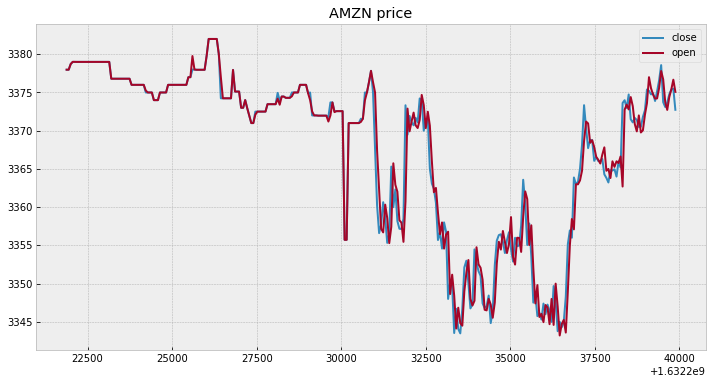

In [135]:
plot_fields =  ['close', 'open']

fig = plt.figure(figsize=(12, 6))
plt.plot(AMZN['time'], AMZN[plot_fields])
plt.legend(plot_fields)
plt.title("AMZN price")

plt.show()

Работать с ценами не очень удобно, перейду к доходностям

In [134]:
AMZN['returns'] = AMZN.loc[:, 'close'].pct_change()

<ipython-input-134-2f5225d6422a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN['returns'] = AMZN.loc[:, 'close'].pct_change()


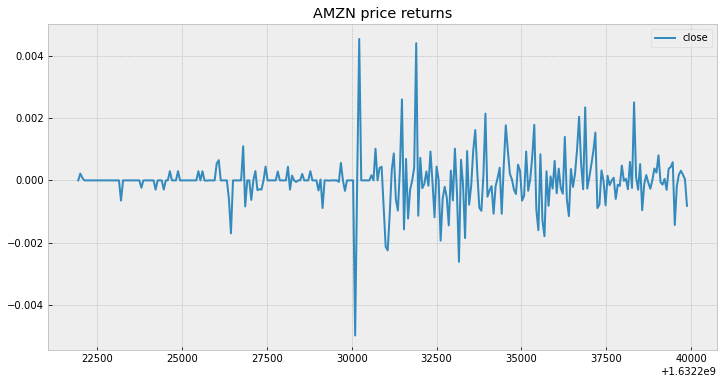

In [143]:
fig = plt.figure(figsize=(12, 6))

plt.plot(AMZN['time'], AMZN['returns'])
plt.legend(plot_fields)
plt.title("AMZN price returns")

plt.show()

Посмотрю на график функции автокорреляции

In [144]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

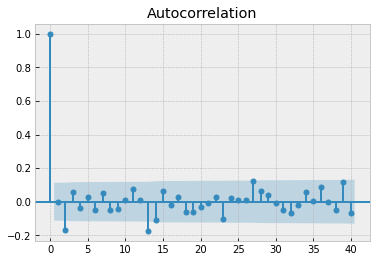

In [149]:
plot_acf(AMZN['returns'].iloc[1:], alpha=0.05, lags=40)
plt.show()

Как видно, даже на 27 лаге автокорреляция практически выходит за доверительный интервал (из-за того что данные поминутные), поэтому в модели авторегрессии возьму побольше лагов

In [166]:
from sklearn.linear_model import LinearRegression

In [164]:
for i in range(1, 50):
    AMZN[f'lag_number_{i}'] = AMZN['returns'].shift(i)

<ipython-input-164-2e8a190923c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMZN[f'lag_number_{i}'] = AMZN['returns'].shift(i)


Строим модель авторегрессии:

In [174]:
X = AMZN.dropna()[[f'lag_number_{i}' for i in range(1, 50)]]
y = AMZN.dropna()['returns']
X_train, y_train, X_test, y_test = X.iloc[:-11], y.iloc[:-11], X.iloc[-10:], y.iloc[-10:]

In [175]:
reg = LinearRegression().fit(X_train, y_train)

In [180]:
y_res = reg.predict(X_test)

In [181]:
from sklearn.metrics import mean_squared_error

In [182]:
mean_squared_error(y_res, y_test)

6.500923961584698e-07

В целом, ошибка получилась небольшой. Можно считать, что модель удачная